---
title: "fit"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

We will make a little parenthesis to talk about a very important topic: **fitting**.

See below temperature data inside and outside a greenhouse, for a period of about 2 weeks.

![](gh_erez.jpg)

::: {.column-margin}
[Erez Feuer's greenhouse](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiQ8bHa0suDAxVMXvEDHVsXCMIQFnoECA0QAQ&url=https%3A%2F%2Fwww.ynet.co.il%2Fenvironment-science%2Farticle%2Fbkhlgjk49&usg=AOvVaw25yr2RjpAaEYNQ7DXK03AW&opi=89978449){target="_blank"}
:::

In [5]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
# avoid "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame."
pd.options.mode.chained_assignment = None  # default='warn'
# %matplotlib widget

In [14]:
#| code-summary: "load data from csv"
df = pd.read_csv('greenhouse_cooling.csv', index_col='time', parse_dates=True)
# df

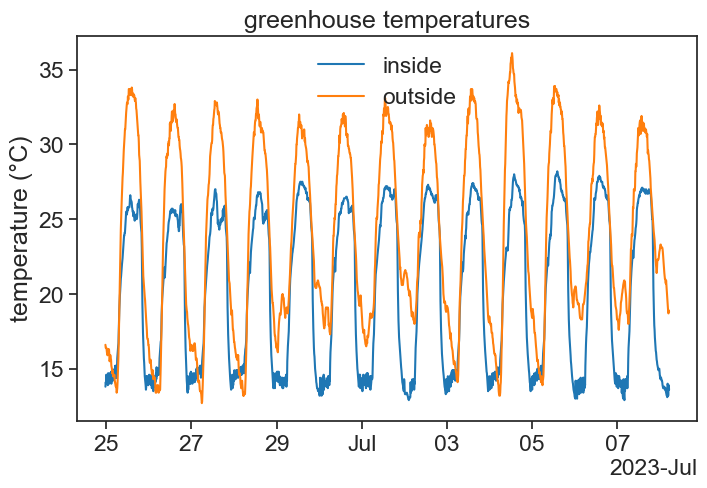

In [4]:
#| code-summary: "plot temperatures"
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df['T_in'], c='tab:blue', label='inside')
ax.plot(df['T_out'], c='tab:orange', label='outside')
ax.set(ylabel='temperature (°C)',
       title="greenhouse temperatures")

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(frameon=False);

Every evening, at 20:00, the air conditioning turns on, and we see a fast decrease in temperature:

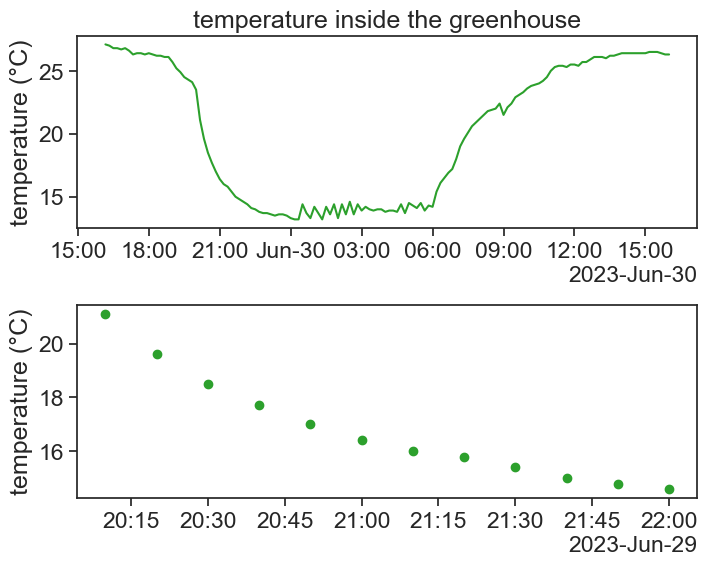

In [35]:
#| code-summary: "chose one evening, plot it"

df_fit = df['2023-06-29 20:10:00':'2023-06-29 22:00:00']

fig, ax = plt.subplots(2, 1, figsize=(8,6))
fig.subplots_adjust(hspace=0.4)  # Adjust the vertical space between subplots

ax[0].plot(df.loc['2023-06-29 16:10:00':'2023-06-30 16:00:00', 'T_in'], color='tab:green')
ax[0].set(ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

ax[1].scatter(df_fit['T_in'].index, df_fit['T_in'], color='tab:green')
ax[1].set(ylabel='temperature (°C)',)

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(formatter)

locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)

The AC is able to bring the temperature down, but up to a limit. The AC can work at a maximum given power, and the cooler it is outside, the more effectively the AC will be able to bring down the temperature inside the greenhouse. We can imagine that the AC behaves as an effective external environment to the greenhouse, and the greenhouse cools down according to [Newton's law of cooling](https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling):

$$
\frac{dT}{dt} = r\cdot (T_{\text{env}}-T)
$$

::: {.column-margin}
* $T=$ the greenhouse temperature
* $T_{\text{env}}=$ the outside environment temperature
* $r=$ coefficient of heat transfer.
:::

The cooling rate is proportional to the difference in temperature between the inside and outside.
Assuming $T_{\text{env}}$ and $r$ to be constant, the solution of this differential equation is:

$$
T(t) = T_{\text{env}} + \left(T_0 - T_{\text{env}} \right)e^{-rt}.
$$

::: {.column-margin}
* $T_0=$ the initial greenhouse temperature
:::

We want to check if the temperature measured inside the greenhouse behaves like Newton's law of cooling, and if so, what can we say about the cooling coefficient $r$ and about $T_{\text{env}}$.

## linear fit

The following is a **very short** introduction to curve fitting. The natural place to start is with a linear fit.

In [5]:
#| code-summary: "linear fit"
# the "fit" process can't deal with datetimes
# we therefore make a new column 'minutes', that will be used here
df_fit['minutes'] = (df_fit.index - df_fit.index[0]).total_seconds() / 60
# linear Fit (degree 1)
degree = 1
coeffs = np.polyfit(df_fit['minutes'], df_fit['T_in'], degree)
# linear Function
linear_function = np.poly1d(coeffs)

starting at 19.80 degrees,
the temperature decreases by 0.05 degrees every minute.


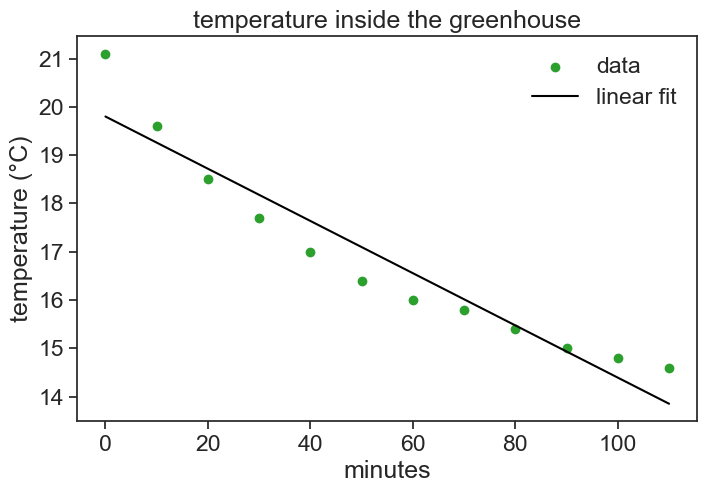

In [6]:
#| code-summary: "see result of linear fit"

fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df_fit['minutes'], df_fit['T_in'],
           color='tab:green', label='data')
ax.plot(df_fit['minutes'], linear_function(df_fit['minutes']),
        color='black', label='linear fit')

ax.set(xlabel='minutes',
       ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

ax.legend(frameon=False)
print(f"starting at {coeffs[1]:.2f} degrees,\nthe temperature decreases by {-coeffs[0]:.2f} degrees every minute.")

The line above is the "best" straight line that describes our data. Defining the residual as the difference between our data and our model (straight line),

$$
e = T_{\text{data}} - T_{\text{model}},
$$

the straight line above is the one that **minimizes** the sum of the squares of residuals. For this reason, the method used above to fit a curve to the data is called "least-squares method".

::: {.column-margin}
it minimizes the sum

$$
S = \sum_i e_i^2
$$
:::

Can we do better than a straight line?

## polynomial fit

In [7]:
#| code-summary: "polynomial fit"

# polynomial fit (degree 2)
degree = 2
coeffs2 = np.polyfit(df_fit['minutes'], df_fit['T_in'], degree)
quad_function = np.poly1d(coeffs2)

# polynomial fit (degree 2)
degree = 3
coeffs3 = np.polyfit(df_fit['minutes'], df_fit['T_in'], degree)
cubic_function = np.poly1d(coeffs3)

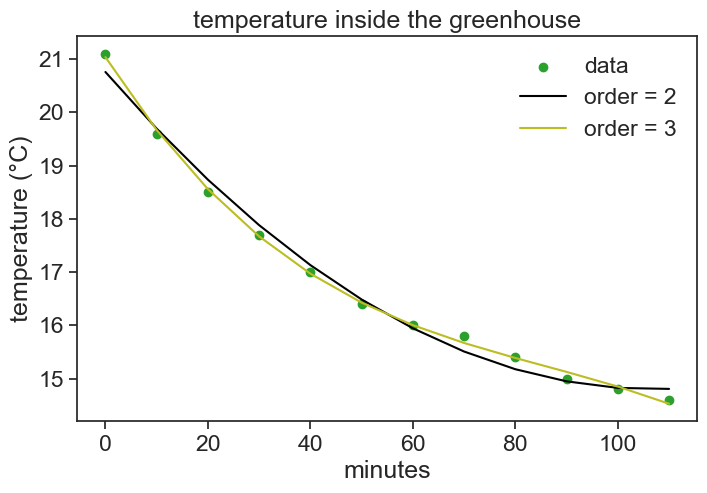

In [17]:
#| code-summary: "see result of polynomial fit"

fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df_fit['minutes'], df_fit['T_in'],
           color='tab:green', label='data')
ax.plot(df_fit['minutes'], quad_function(df_fit['minutes']),
        color='black', label='order = 2')
ax.plot(df_fit['minutes'], cubic_function(df_fit['minutes']),
        color='tab:olive', label='order = 3')

ax.set(xlabel='minutes',
       ylabel='temperature (°C)',
       title="temperature inside the greenhouse")
ax.legend(frameon=False)

## any function you want

Now let's get back to our original assumption, that the greenhouse cools according to Newton's cooling law. We can still use the least-squares method for any function we want!

In [9]:
#| code-summary: "define new function"
def cooling(t, T_env, T0, r):
    """
    t = time
    other stuff = parameters to be fitted
    """
    return T_env + (T0 - T_env)*np.exp(-r*t)

In [10]:
#| code-summary: "use scipy's curve_fit"

t = df_fit['minutes'].values
y = df_fit['T_in'].values

T_init = df_fit['T_in'][0]

popt, pcov = curve_fit(f=cooling,             # model function
                     xdata=t,                 # x data
                     ydata=y,                 # y data
                     p0=(2, T_init, 0.5),     # initial guess of the parameters
                     )
print(f"the optimal parameters are {popt}")

the optimal parameters are [14.01663586 21.0074623   0.02121802]


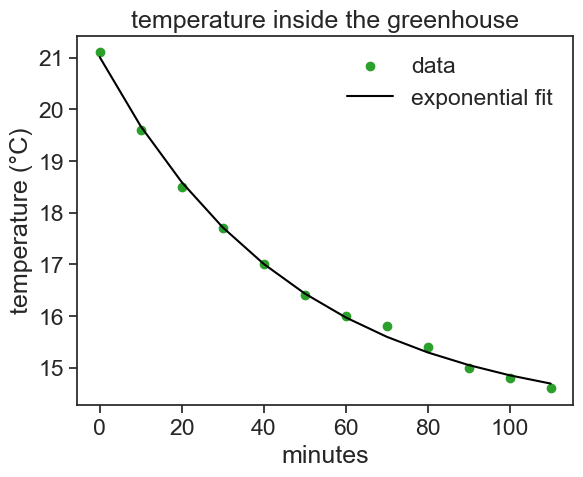

In [11]:
#| code-summary: "see result of exponential fit"
fig, ax = plt.subplots(sharex=True)

ax.scatter(df_fit['minutes'], df_fit['T_in'],
           color='tab:green', label='data')
ax.plot(t, cooling(t, *popt),
        color='black', label='exponential fit')

ax.set(xlabel='minutes',
       ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

ax.legend(frameon=False)

That looks really good :)

We can use curve fitting to retrieve important parameters from our data.
Let's write a function that executes the fit and returns two of the fitted parameters: `T_env` and `r`.

In [12]:
#| code-summary: "define function to retrieve parameters"
def run_fit(data):
    data['minutes'] = (data.index - data.index[0]).total_seconds() / 60
    t = data['minutes'].values
    y = data['T_in'].values
    T_init = data['T_in'][0]
    popt, pcov = curve_fit(f=cooling,             # model function
                        xdata=t,              # x data
                        ydata=y,              # y data
                        p0=(2, T_init, 0.5),   # initial guess of the parameters
                        )
    return popt[0],popt[2]

We now apply this function to several consecutive evenings, and we keep the results in a new dataframe.

In [13]:
#| code-summary: "define function to retrieve parameters"
df_night = df.between_time('20:01', '22:01', inclusive='left')

# group by day and apply the function
# this is where the magic happens.
# if you are not familiar with "groupby", this will be hard to understand
result_series = df_night.groupby(df_night.index.date).apply(run_fit)

# convert the series to a dataframe
result_df = pd.DataFrame(result_series.tolist(), index=result_series.index, columns=['T_env', 'r'])
result_df.index = pd.to_datetime(result_df.index)
result_df

,T_env,r
2023-06-25,13.275540,0.019354
2023-06-26,13.331949,0.027034
2023-06-27,13.254827,0.018753
2023-06-28,13.392919,0.020449
2023-06-29,14.016636,0.021218
2023-06-30,13.807517,0.021749
2023-07-01,14.994207,0.023504
2023-07-02,14.314220,0.023705
2023-07-03,14.585848,0.019438
2023-07-04,14.377220,0.019504


Text(0, 0.5, '"outside" temp.\ninferred from\nanalysis')

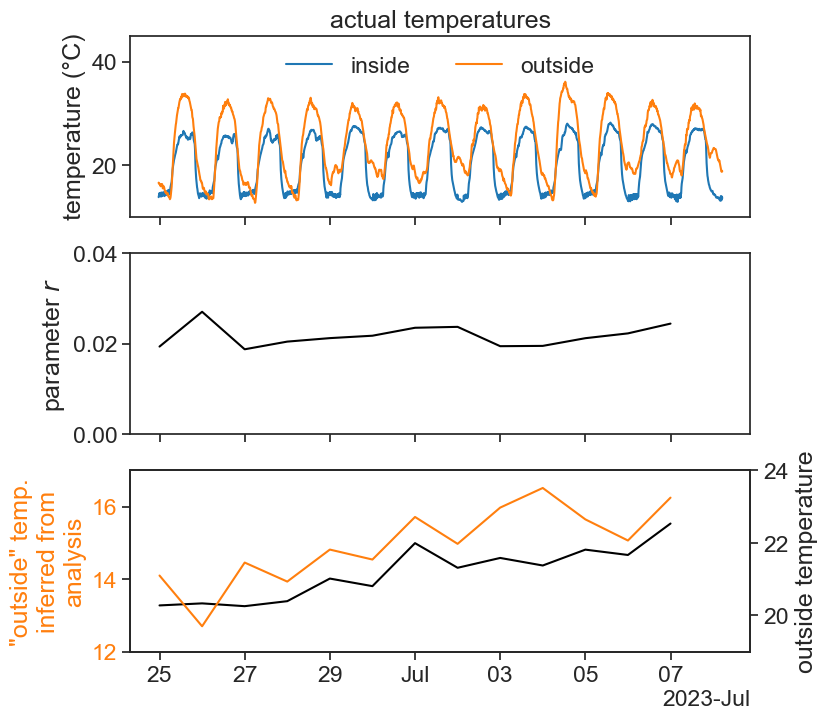

In [14]:
fig, ax = plt.subplots(3,1,sharex=True, figsize=(8,8))

ax[0].plot(df['T_in'], c='tab:blue', label='inside')
ax[0].plot(df['T_out'], c='tab:orange', label='outside')
ax[0].set(ylabel='temperature (°C)',
          title="actual temperatures",
          ylim=[10,45])

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(formatter)

ax[0].legend(ncol=2, loc='upper center', frameon=False)

ax[1].plot(result_df['r'], color='black')
ax[1].set(ylabel=r"parameter $r$",
          ylim=[0, 0.04])

ax[2].plot(result_df['T_env'], color='black')
ax2b = ax[2].twinx()
ax2b.plot(df_night['T_out'].resample('D').mean(), color='tab:orange')
ax[2].set(ylim=[12, 17])
ax2b.set(ylim=[19, 24],
        ylabel='outside temperature')
# color the xticks
for tick in ax[2].get_yticklabels():
    tick.set_color('tab:orange')
# color the xlabel
ax[2].set_ylabel(r'"outside" temp.'+'\ninferred from\nanalysis', color='tab:orange')

Conclusions:

1. The cooling coefficient $r$ seems quite stable throughout the two weeks of measurements. This probably says that the greenhouse and AC properties did not change much. For instance, the greenhouse thermal insulation stayed constant, and the AC power output stayed constant.
1. The AC tracks very well the outside temperature! This is to say: the AC works better (more easily) when temperatures outsides are low, and vice-versa.